In [1]:
import os
import copy
import json
import argparse

import numpy as np
from tqdm import tqdm
import tensorflow as tf

from network_models.policy_dcgan import Policy_dcgan
from network_models.discriminator import Discriminator
from network_models.sn_discriminator import SNDiscriminator
from algo.ppo import PPOTrain
from algo.trpo import TRPOTrain
from utils import generator

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

/root/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/root/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dir_name = 'ppo_5'
model = 'model-200.ckpt'
log_dir = os.path.join('./log', dir_name)
ckpt_path = os.path.join('./trained_models', dir_name, model)
gpu_num = '0'
batch_size = 32
with open(os.path.join(log_dir, 'config.json'), 'r') as f:
    config = json.load(f)
config['obs_size'] = 64
obs_shape = [3, config['obs_size'], config['obs_size'], 1]
config

{'D_step': 1,
 'G_step': 3,
 'algo': 'trpo',
 'batch_size': 32,
 'c_entropy': 0.01,
 'c_l1': 1.0,
 'c_vf': 0.2,
 'data': '../../dataset/mnist_test_seq.npy',
 'gamma': 0.95,
 'initia_learning_rate': 0.0001,
 'iteration': 250,
 'leaky': True,
 'lr_schedules': 100,
 'obs_size': 64,
 'vf_clip': ''}

In [3]:
# moving mnist 読み込み
data_path = '../../dataset/mnist_test_seq.npy'
data = np.load(data_path)
# generator
gen = generator(data,
        batch_size=batch_size, img_size=config['obs_size'])
expert_batch = next(gen)
agent_batch = expert_batch[:, :3, :, :, :]

In [4]:
# policy net
Policy = Policy_dcgan(
        'policy',
        obs_shape=obs_shape,
        batch_size=batch_size,
        decode=True,
        leaky=config['leaky'])
Old_Policy = Policy_dcgan(
        'old_policy',
        obs_shape=obs_shape,
        batch_size=batch_size,
        decode=True,
        leaky=config['leaky'])

if config['algo'] == 'ppo':
    print('build ppo agent')
    Agent = PPOTrain(
                    Policy,
                    Old_Policy,
                    obs_shape=obs_shape,
                    gamma=config['gamma'],
                    c_vf=config['c_vf'],
                    c_entropy=config['c_entropy'],
                    c_l1=config['c_l1'],
                    obs_size=64,
                    vf_clip=config['vf_clip'])
elif config['algo'] == 'trpo':
    print('build trpo agent')
    Agent = TRPOTrain(
                    Policy,
                    Old_Policy,
                    obs_shape=obs_shape,
                    gamma=config['gamma'],
                    c_vf=config['c_vf'],
                    c_entropy=config['c_entropy'],
                    c_l1=config['c_l1'],
                    obs_size=64,
                    vf_clip=config['vf_clip'])
else:
    raise ValueError('Invalid algo name')

if not 'spectral normalization' in config.keys():
    config['spectral normalization'] = ''
if config['spectral normalization']:
    print('build sngan discriminator')
    D = SNDiscriminator(obs_shape=obs_shape,
                batch_size=batch_size)
else:
    print('build dcgan discriminator')
    D = Discriminator(obs_shape=obs_shape,
                batch_size=batch_size,
                leaky=config['leaky'])

build trpo agent
build dcgan discriminator


In [24]:
# session config
sess_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list=gpu_num,
        allow_growth=True
        ))

with tf.Session(config=sess_config) as sess:
    saver = tf.train.Saver()
    # initialize Session
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, ckpt_path)
    
    mu, sigma = Policy.get_mu_sigma(agent_batch)

INFO:tensorflow:Restoring parameters from ./trained_models/trpo_1/model-200.ckpt


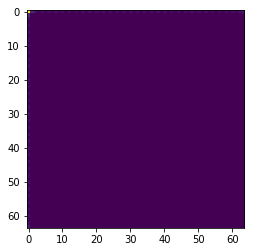

In [25]:
img = mu[0]
img = np.reshape(img, (64, 64))
plt.imshow(img)

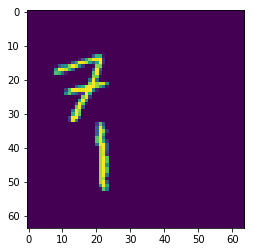

In [13]:
img = np.reshape(agent_batch[0][0], (64*64))
img = np.reshape(img, (64, 64))
plt.imshow(img)

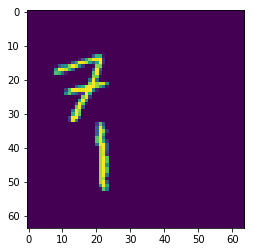

In [12]:
plt.imshow(np.squeeze(agent_batch[0][0], axis=2))